In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

print ("Tensorflow Version", tf.__version__)

2024-03-10 20:39:47.063856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 20:39:47.063986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 20:39:47.207761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Tensorflow Version 2.15.0


In [3]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = 'latin',header=None)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns = ["sentiment","id","date","query","user_id","text"]

In [6]:
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df = df.drop(['id','date','query','user_id'],axis=1)

In [8]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
    return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x:label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


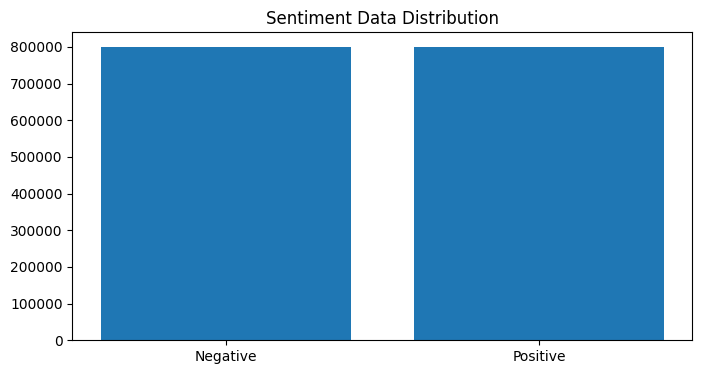

In [9]:
#to check if the data is balanced or not.
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution");

In [10]:
import random
#create random idexes to choose the df
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)]
#returns the rows with the index and displays it
df.loc[random_idx_list,:].head(10)

,sentiment,text
71622,Negative,took about 3 ambien waiting for them to work.....
747435,Negative,Hay fever is bad today aaccchhhooo
155591,Negative,@duyku Apparently I wasn't ready enough... I ...
109099,Negative,Getting ready to go mimis...I really want to g...
1477405,Positive,my back is so sunburnt going swimming in a t s...
1414609,Positive,Uploading pics onto Facebook &amp; Myspace
598090,Negative,@PaulaLanzador my tv is pants and can't watch ...
814144,Positive,@shewhowearsred yea it's pretty slick. Nice in...
134617,Negative,"Well, now I offically know how to put the chai..."
786294,Negative,is not in Melbourne this week like i was meant...


In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

text_cleaning_re = "@\S+|http?:\S|[^A-Za-z0-9]+"

In [12]:
def preprocess(text,stem=False):
    text = re.sub(text_cleaning_re, " ",str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)
df.text = df.text.apply(lambda x: preprocess(x))

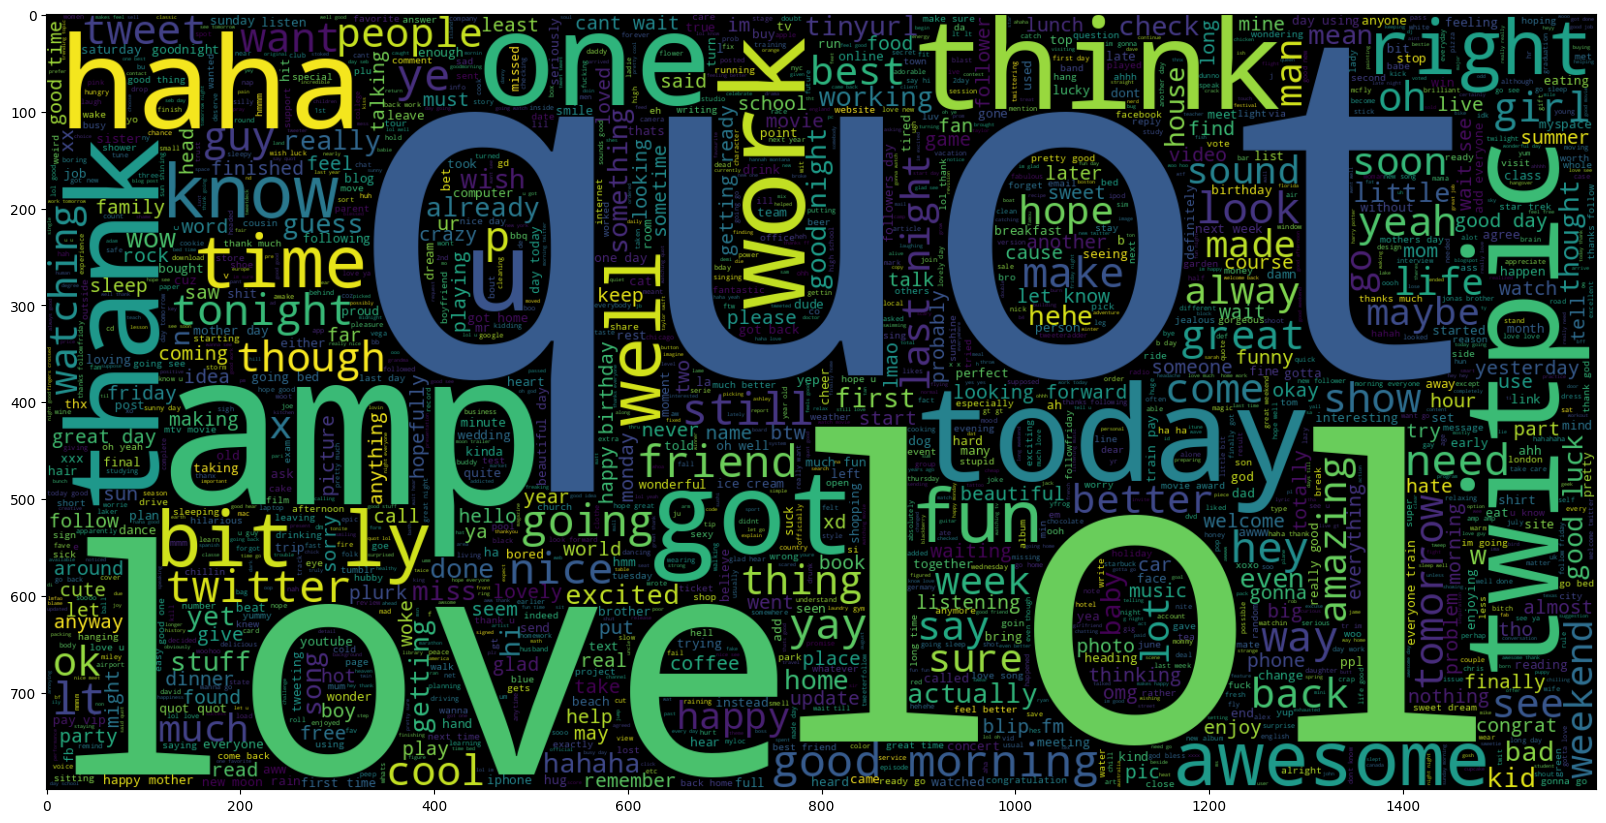

In [13]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

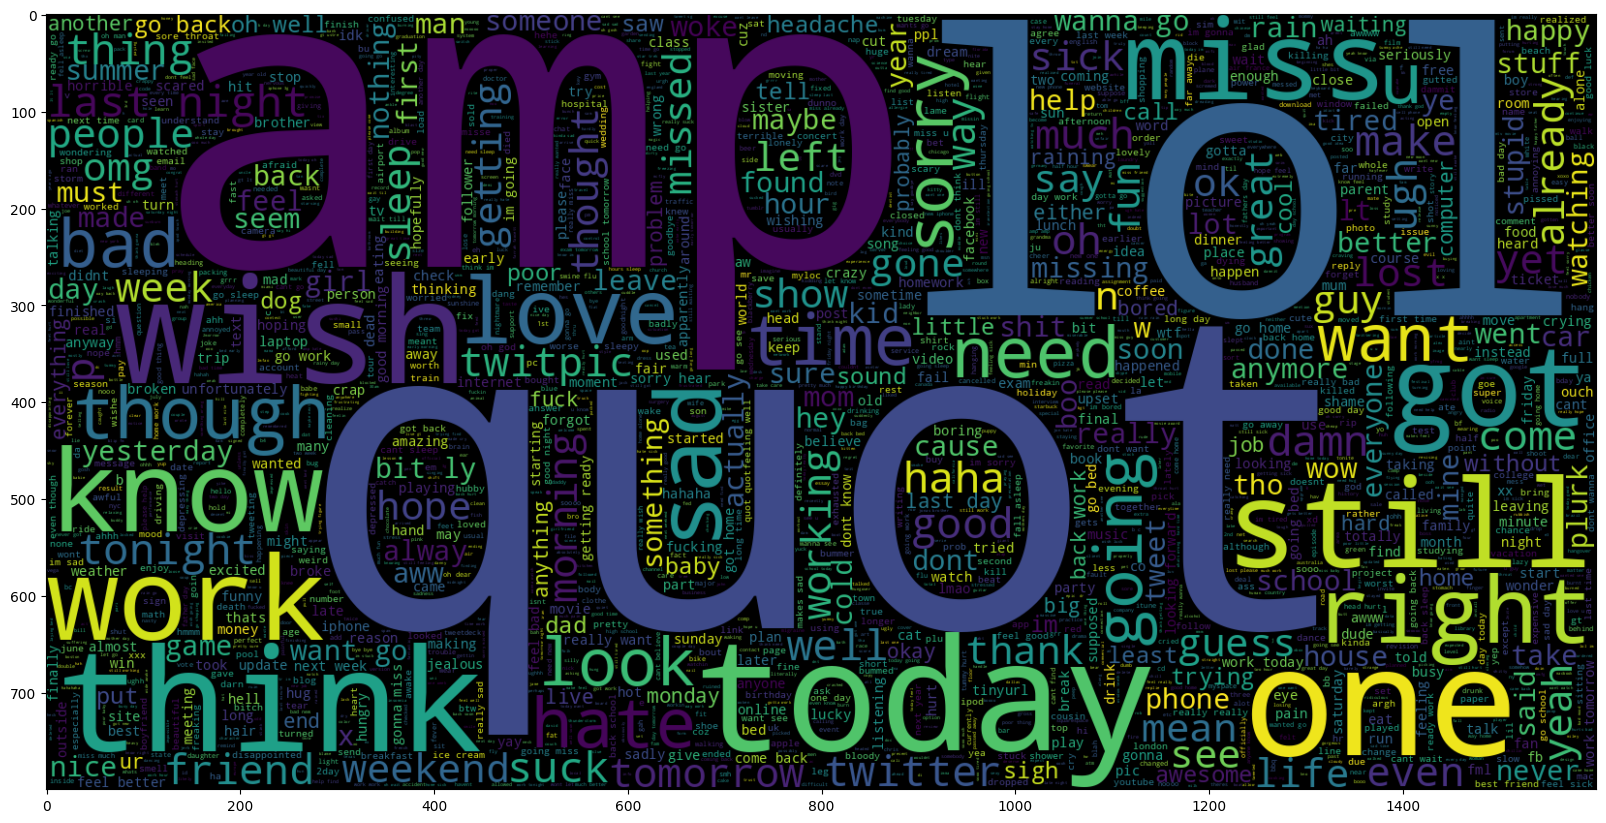

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [15]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [16]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,random_state=7) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [17]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,twitpic com 5dflq amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 341204


In [19]:
from keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [20]:
labels = train_data.sentiment.unique().tolist()

In [21]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [22]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-03-10 20:44:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-10 20:44:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-10 20:44:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [23]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [24]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMBEDDING_DIM,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [28]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [31]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [32]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 102361200 elements. This may consume a large amount of memory.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 82ms/step - accuracy: 0.7456 - loss: 0.5074 - val_accuracy: 0.7902 - val_loss: 0.4456 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 82ms/step - accuracy: 0.8033 - loss: 0.4245 - val_accuracy: 0.7915 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 82ms/step - accuracy: 0.8291 - loss: 0.3771 - val_accuracy: 0.7889 - val_loss: 0.4547 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 104s 83ms/step - accuracy: 0.8458 - loss: 0.3439 - val_accuracy: 0.7867 - val_loss: 0.4740 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 103s 82ms/step - accuracy: 0.8576 - loss: 0.3177 - val_accuracy: 0.7863 - val_loss: 0.4921 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 103s 82ms/step - accuracy: 0.8661 - loss: 0.2972 - val_accuracy: 0.7826 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 103s 83ms/step - accuracy: 

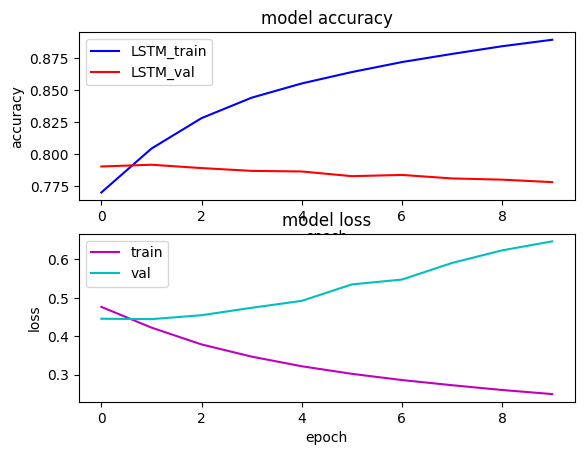

In [33]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [34]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


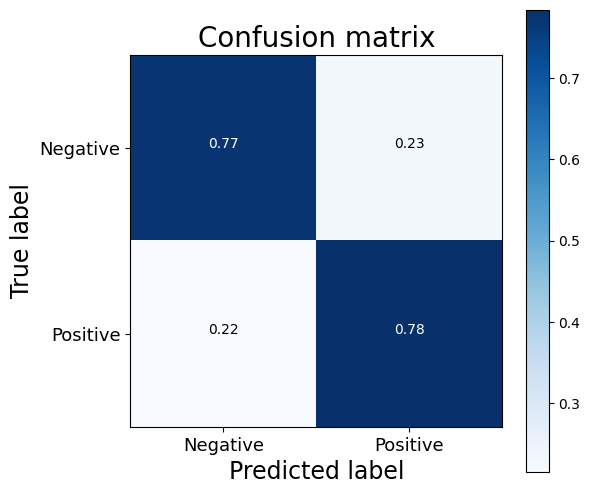

In [35]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [36]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.77      0.78    160542
    Positive       0.77      0.78      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

